In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
#import optuna
#from optuna.trial import Trial

from functools import partial
optuna.logging.set_verbosity(optuna.logging.FATAL)

ModuleNotFoundError: No module named 'optuna'

In [5]:
mpd_stats = pd.read_csv('../data/mpd_stats.csv')
mpd_stats.market.unique()

array(['bac', 'citi', 'corn', 'euro', 'gold', 'infl1y', 'infl2y',
       'infl5y', 'iyr', 'LR3y3m', 'LR5y3m', 'oil', 'pound', 'silver',
       'soybns', 'sp12m', 'sp6m', 'tr10yr', 'tr5yr', 'wheat', 'yen'],
      dtype=object)

In [7]:
ticker_mpd = ['bac', 'citi']
tickers=('BAC', 'C')
#ticker_mpd = ['corn', 'soybns']
#tickers=('CORN', 'SOYB')
security1 = tickers[0]
security2 = tickers[1]

In [8]:
mpd_stats = mpd_stats[mpd_stats.market.isin(ticker_mpd)]

mpd_stats.market = mpd_stats.market.replace({ticker_mpd[0]:tickers[0], ticker_mpd[1]:tickers[1]})
mpd_stats.idt = pd.to_datetime(mpd_stats.idt, format='%m/%d/%Y')
mpd_stats = mpd_stats.set_index('idt')
mpd_stats

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc
idt,,,,,,,,,,,,,
2010-01-15,BAC,3.0,-0.02514,0.18210,-0.38173,0.85192,-0.25389,-0.01634,0.19272,-20.0,0.14898,20.0,0.09307
2010-01-29,BAC,3.0,-0.02194,0.21265,-0.79513,1.61552,-0.28826,0.00001,0.21786,-20.0,0.16750,20.0,0.12009
2010-02-12,BAC,3.0,-0.01699,0.21625,-0.86181,1.83248,-0.28670,0.00720,0.22358,-20.0,0.16404,20.0,0.12713
2010-02-26,BAC,3.0,-0.00965,0.17893,-0.70108,1.40641,-0.23570,0.00776,0.19373,-20.0,0.12882,20.0,0.09233
2010-03-15,BAC,3.0,0.00006,0.17357,-0.71889,1.63480,-0.21657,0.01649,0.19608,-20.0,0.11325,20.0,0.09545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,C,3.0,-0.00156,0.12235,-0.34116,0.91728,-0.15510,0.00443,0.14296,-20.0,0.05898,20.0,0.03996
2023-12-20,C,3.0,-0.00406,0.13064,-0.14578,0.79576,-0.16615,-0.00137,0.15344,-20.0,0.06728,20.0,0.05266
2023-12-27,C,3.0,-0.00230,0.12846,-0.30241,0.89189,-0.16268,0.00337,0.15010,-20.0,0.06524,20.0,0.04786


In [9]:
spread = mpd_stats[mpd_stats.market == tickers[0]].iloc[:,1:] - mpd_stats[mpd_stats.market == tickers[1]].iloc[:,1:]
spread=spread.drop(columns=['maturity_target', 'lg_change_incr', 'lg_change_decr'])
spread.index = pd.to_datetime(spread.index, format='%Y/%m/%d')
spread.reset_index(inplace=True)
spread

,idt,mu,sd,skew,kurt,p10,p50,p90,prDec,prInc
0,2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,-0.03349,-0.03009
1,2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,-0.02622,-0.00855
2,2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,-0.03983,0.03234
3,2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,-0.07900,-0.01294
4,2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,-0.12750,-0.05782
...,...,...,...,...,...,...,...,...,...,...
608,2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,-0.00451,-0.00612
609,2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,-0.00404,-0.00199
610,2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,-0.00678,-0.00524
611,2024-01-03,0.00418,-0.00149,-0.16433,0.07588,0.00408,0.00702,0.00088,-0.00216,-0.00274


In [10]:
spread['prInc'].mean()

0.005108336052202284

In [11]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] <= 0.01:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")
        

In [12]:
for col in spread.columns[1:]:
    print(col)
    check_stationarity(spread[col])

mu
ADF Statistic: -4.799711630364353
p-value: 5.445505880122751e-05
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.
sd
ADF Statistic: -3.9772557527183627
p-value: 0.001534402925698162
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.
skew
ADF Statistic: -3.1194328875654302
p-value: 0.025148094898213402
Critical Values: {'1%': -3.4414256033746606, '5%': -2.8664262627821473, '10%': -2.569372254520843}
The time series is not stationary.
kurt
ADF Statistic: -2.950952696417932
p-value: 0.0397356559504387
Critical Values: {'1%': -3.441406876071572, '5%': -2.866418015869717, '10%': -2.5693678601956718}
The time series is not stationary.
p10
ADF Statistic: -4.625172878935438
p-value: 0.00011605114075607749
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.


In [13]:
spread.columns[1:]

Index(['mu', 'sd', 'skew', 'kurt', 'p10', 'p50', 'p90', 'prDec', 'prInc'], dtype='object')

In [14]:
check_stationarity(spread['mu'])

ADF Statistic: -4.799711630364353
p-value: 5.445505880122751e-05
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.


<Axes: >

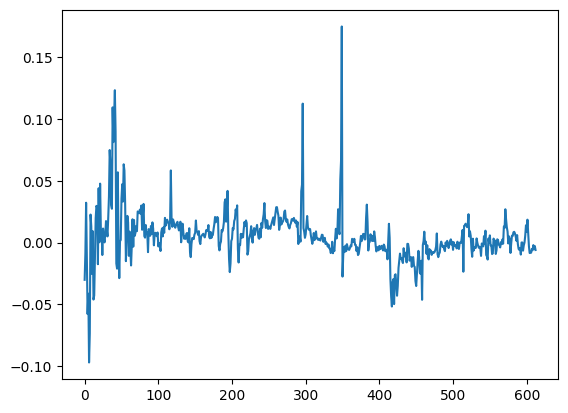

In [15]:
spread.prInc.plot()

<Axes: >

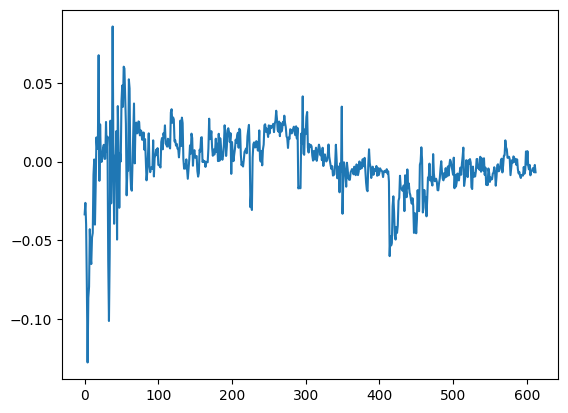

In [16]:
spread.prDec.plot()

# Helper Functions for Spread data Fetching

In [17]:
quandl.ApiConfig.api_key = 'NrLR6iDUF3zksCBL5eDQ'

In [18]:
@functools.lru_cache(maxsize=16)
def fetch_etf_data_quadl(ticker,start_date,end_date):
    return quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte':start_date,'lte': end_date}, ticker=ticker)

In [19]:
@functools.lru_cache(maxsize=16)
def get_processed_data( tickers):
    security1 = tickers[0]
    security2 = tickers[1]
    
    rawdata_security1 = fetch_etf_data_quadl(security1 ,'2010-01-15','2024-01-10')
    rawdata_security2 = fetch_etf_data_quadl(security2 ,'2010-01-15','2024-01-10')

    rawdata_combined = pd.concat([rawdata_security1, rawdata_security2]).sort_values(['ticker','date']).reset_index(drop=True)

    rawdata_combined['adj_typical_price'] = (rawdata_combined['adj_high'] +  
                                             rawdata_combined['adj_low'] + rawdata_combined['adj_close']) / 3

    rawdata_combined['adj_dollar_vol'] = rawdata_combined['adj_volume'] * rawdata_combined['adj_close']

    rawdata_combined['adj_rolling_dollar_vol'] = rawdata_combined.groupby('ticker')['adj_dollar_vol'].rolling(15).median().reset_index(drop=True)
    
    return rawdata_combined

In [20]:
rawdata_combined = get_processed_data(tickers)

In [21]:
# rawdata_combined = rawdata_combined.set_index('date')
rawdata_combined 

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,adj_typical_price,adj_dollar_vol,adj_rolling_dollar_vol
0,BAC,2010-01-15,16.64,16.6500,16.23,16.26,195117100.0,0.0,1.0,13.548581,13.556723,13.214751,13.239178,195117100.0,13.336884,2.583190e+09,NaN
1,BAC,2010-01-19,16.06,16.4700,15.84,16.32,181616500.0,0.0,1.0,13.076334,13.410164,12.897207,13.288031,181616500.0,13.198467,2.413326e+09,NaN
2,BAC,2010-01-20,16.22,16.6300,16.18,16.49,288741100.0,0.0,1.0,13.206609,13.540439,13.174041,13.426448,288741100.0,13.380309,3.876767e+09,NaN
3,BAC,2010-01-21,16.46,16.6600,15.20,15.47,551285500.0,0.0,1.0,13.402022,13.564865,12.376107,12.595946,551285500.0,12.845639,6.943962e+09,NaN
4,BAC,2010-01-22,15.26,15.5200,14.71,14.90,369620800.0,0.0,1.0,12.424960,12.636657,11.977141,12.131842,369620800.0,12.248547,4.484181e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,C,2024-01-04,53.92,54.7474,53.66,53.77,22515082.0,0.0,1.0,53.410323,54.229902,53.152780,53.261741,22515082.0,53.548141,1.199192e+09,8.677539e+08
7036,C,2024-01-05,54.03,54.6700,53.89,54.33,16856047.0,0.0,1.0,53.519283,54.153233,53.380606,53.816447,16856047.0,53.783429,9.071326e+08,8.677539e+08
7037,C,2024-01-08,53.99,54.0900,53.02,54.01,17181918.0,0.0,1.0,53.479661,53.578716,52.518830,53.499472,17181918.0,53.199006,9.192235e+08,8.677539e+08
7038,C,2024-01-09,53.85,53.9100,53.27,53.48,17151601.0,0.0,1.0,53.340984,53.400417,52.766467,52.974482,17151601.0,53.047122,9.085972e+08,8.677539e+08


In [22]:
merged_data = mpd_stats.merge(rawdata_combined, left_on=['idt','market'] , right_on=['date','ticker'])
merged_data

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,...,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,adj_typical_price,adj_dollar_vol,adj_rolling_dollar_vol
0,BAC,3.0,-0.02514,0.18210,-0.38173,0.85192,-0.25389,-0.01634,0.19272,-20.0,...,0.0,1.0,13.548581,13.556723,13.214751,13.239178,195117100.0,13.336884,2.583190e+09,NaN
1,BAC,3.0,-0.02194,0.21265,-0.79513,1.61552,-0.28826,0.00001,0.21786,-20.0,...,0.0,1.0,12.612230,12.661084,12.286543,12.359823,175135300.0,12.435817,2.164641e+09,NaN
2,BAC,3.0,-0.01699,0.21625,-0.86181,1.83248,-0.28670,0.00720,0.22358,-20.0,...,0.0,1.0,11.781729,11.838724,11.627027,11.765444,162819300.0,11.743732,1.915641e+09,2.454737e+09
3,BAC,3.0,-0.00965,0.17893,-0.70108,1.40641,-0.23570,0.00776,0.19373,-20.0,...,0.0,1.0,13.491585,13.711424,13.361311,13.564865,343669400.0,13.545867,4.661829e+09,2.731721e+09
4,BAC,3.0,0.00006,0.17357,-0.71889,1.63480,-0.21657,0.01649,0.19608,-20.0,...,0.0,1.0,13.638329,13.776830,13.516121,13.727947,120308200.0,13.673633,1.651585e+09,2.346568e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,C,3.0,-0.00156,0.12235,-0.34116,0.91728,-0.15510,0.00443,0.14296,-20.0,...,0.0,1.0,47.546281,49.056866,47.407605,48.873615,21182611.0,48.446029,1.035271e+09,7.042706e+08
1220,C,3.0,-0.00406,0.13064,-0.14578,0.79576,-0.16615,-0.00137,0.15344,-20.0,...,0.0,1.0,50.220760,50.607073,49.398605,49.596715,16821437.0,49.867464,8.342880e+08,8.677539e+08
1221,C,3.0,-0.00230,0.12846,-0.30241,0.89189,-0.16268,0.00337,0.15010,-20.0,...,0.0,1.0,50.656601,51.092442,50.448586,50.973576,9844096.0,50.838201,5.017888e+08,8.342880e+08
1222,C,3.0,-0.00257,0.13001,-0.23665,0.77179,-0.16456,0.00152,0.15372,-20.0,...,0.0,1.0,52.746656,53.851116,51.736297,53.132970,30341951.0,52.906794,1.612158e+09,8.342880e+08


In [23]:
window=8
spread_cols = list(mpd_stats.columns) + ['date', 'adj_close', 'adj_volume']
merged_data_filtered = merged_data[spread_cols].set_index('date')
merged_data_filtered.groupby('market')['adj_close']
merged_data_filtered

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume
date,,,,,,,,,,,,,,,
2010-01-15,BAC,3.0,-0.02514,0.18210,-0.38173,0.85192,-0.25389,-0.01634,0.19272,-20.0,0.14898,20.0,0.09307,13.239178,195117100.0
2010-01-29,BAC,3.0,-0.02194,0.21265,-0.79513,1.61552,-0.28826,0.00001,0.21786,-20.0,0.16750,20.0,0.12009,12.359823,175135300.0
2010-02-12,BAC,3.0,-0.01699,0.21625,-0.86181,1.83248,-0.28670,0.00720,0.22358,-20.0,0.16404,20.0,0.12713,11.765444,162819300.0
2010-02-26,BAC,3.0,-0.00965,0.17893,-0.70108,1.40641,-0.23570,0.00776,0.19373,-20.0,0.12882,20.0,0.09233,13.564865,343669400.0
2010-03-15,BAC,3.0,0.00006,0.17357,-0.71889,1.63480,-0.21657,0.01649,0.19608,-20.0,0.11325,20.0,0.09545,13.727947,120308200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,C,3.0,-0.00156,0.12235,-0.34116,0.91728,-0.15510,0.00443,0.14296,-20.0,0.05898,20.0,0.03996,48.873615,21182611.0
2023-12-20,C,3.0,-0.00406,0.13064,-0.14578,0.79576,-0.16615,-0.00137,0.15344,-20.0,0.06728,20.0,0.05266,49.596715,16821437.0
2023-12-27,C,3.0,-0.00230,0.12846,-0.30241,0.89189,-0.16268,0.00337,0.15010,-20.0,0.06524,20.0,0.04786,50.973576,9844096.0


In [24]:
window = 8

merged_data_filtered = merged_data[spread_cols].set_index('date')

for col in ['adj_close', 'prInc', 'prDec']:
    group_means = merged_data_filtered.groupby('market')[col].rolling(window=window).mean().reset_index(level=0, drop=True)
    group_stds = merged_data_filtered.groupby('market')[col].rolling(window=window).std().reset_index(level=0, drop=True)
    normalized_values = (merged_data_filtered[col] - group_means) / group_stds
    merged_data_filtered[f'norm_rolling_{col}'] = normalized_values

merged_data_filtered.tail()

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec
date,,,,,,,,,,,,,,,,,,
2023-12-13,C,3.0,-0.00156,0.12235,-0.34116,0.91728,-0.15510,0.00443,0.14296,-20.0,0.05898,20.0,0.03996,48.873615,21182611.0,1.341389,-1.058432,-1.260903
2023-12-20,C,3.0,-0.00406,0.13064,-0.14578,0.79576,-0.16615,-0.00137,0.15344,-20.0,0.06728,20.0,0.05266,49.596715,16821437.0,1.237476,1.732080,-0.482592
2023-12-27,C,3.0,-0.00230,0.12846,-0.30241,0.89189,-0.16268,0.00337,0.15010,-20.0,0.06524,20.0,0.04786,50.973576,9844096.0,1.379635,0.522321,-0.516224
2024-01-03,C,3.0,-0.00257,0.13001,-0.23665,0.77179,-0.16456,0.00152,0.15372,-20.0,0.06614,20.0,0.05164,53.132970,30341951.0,1.607055,1.120514,-0.166910
2024-01-10,C,3.0,-0.00164,0.12808,-0.27732,0.77154,-0.16220,0.00319,0.15203,-20.0,0.06428,20.0,0.04899,52.518830,16240495.0,1.102542,0.505014,-0.421112


In [25]:
spreads_df = (merged_data_filtered[merged_data_filtered.market==security1].iloc[:,2:] - 
                        merged_data_filtered[merged_data_filtered.market==security2].iloc[:,2:])
spreads_df

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec
date,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,-0.03009,-13.708832,141099400.0,NaN,NaN,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,-0.00855,-13.800234,107192400.0,NaN,NaN,NaN
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,0.03234,-13.291478,143892400.0,NaN,NaN,NaN
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,-0.01294,-13.225555,325813700.0,NaN,NaN,NaN
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,-0.05782,-16.923444,56825300.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,-0.00612,-16.833615,36984538.0,0.078195,0.335625,0.157311
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,-0.00199,-16.616715,27647540.0,0.221072,-0.548732,0.095134
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,-0.00524,-17.133576,14599441.0,0.121571,-0.074412,-0.132969


In [26]:
spreads_df[[ 'norm_rolling_adj_close', 'norm_rolling_prInc', 'norm_rolling_prDec']].corr()

,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec
norm_rolling_adj_close,1.000000,-0.142314,-0.121724
norm_rolling_prInc,-0.142314,1.000000,0.330291
norm_rolling_prDec,-0.121724,0.330291,1.000000


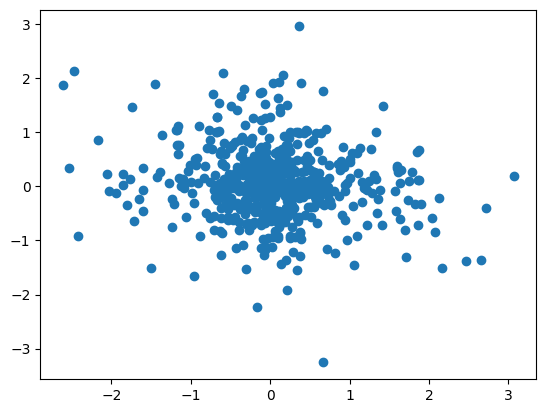

In [27]:
plt.scatter(spreads_df['norm_rolling_adj_close'], spreads_df['norm_rolling_prInc'])

In [28]:
#nd=next day
rawdata_combined_processed = rawdata_combined.sort_values(['ticker','date'])
rawdata_combined_processed = rawdata_combined_processed.set_index(['date'])

rawdata_combined_processed = rawdata_combined_processed[['adj_close', 'adj_volume']]
rawdata_combined_processed[['nd_adj_close', 'nd_adj_volume']] = rawdata_combined_processed[['adj_close', 'adj_volume']].shift(-1)#.dropna()#.reset_index()
rawdata_combined_processed['ticker'] = rawdata_combined.set_index('date').ticker
rawdata_combined_processed

,adj_close,adj_volume,nd_adj_close,nd_adj_volume,ticker
date,,,,,
2010-01-15,13.239178,195117100.0,13.288031,181616500.0,BAC
2010-01-19,13.288031,181616500.0,13.426448,288741100.0,BAC
2010-01-20,13.426448,288741100.0,12.595946,551285500.0,BAC
2010-01-21,12.595946,551285500.0,12.131842,369620800.0,BAC
2010-01-22,12.131842,369620800.0,12.196979,262351600.0,BAC
...,...,...,...,...,...
2024-01-04,53.261741,22515082.0,53.816447,16856047.0,C
2024-01-05,53.816447,16856047.0,53.499472,17181918.0,C
2024-01-08,53.499472,17181918.0,52.974482,17151601.0,C


In [29]:
BAC_data = rawdata_combined_processed[rawdata_combined_processed.ticker==security1][['nd_adj_close', 'nd_adj_volume']]
BAC_data.columns = [security1, f'{security1}_adj_volume']
CITI_data = rawdata_combined_processed[rawdata_combined_processed.ticker==security2][['nd_adj_close', 'nd_adj_volume']]
CITI_data.columns = [security2, f'{security2}_adj_volume']
spreads_df_merged = spreads_df.merge(BAC_data, left_index=True, right_index=True)
spreads_df_merged = spreads_df_merged.merge(CITI_data, left_index=True, right_index=True)
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume
date,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,-0.03009,-13.708832,141099400.0,NaN,NaN,NaN,13.288031,181616500.0,27.893554,80789300.0
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,-0.00855,-13.800234,107192400.0,NaN,NaN,NaN,12.555235,159503300.0,26.317647,23577600.0
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,0.03234,-13.291478,143892400.0,NaN,NaN,NaN,12.343539,205493300.0,26.081261,33228500.0
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,-0.01294,-13.225555,325813700.0,NaN,NaN,NaN,13.605576,170931100.0,26.711624,15568600.0
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,-0.05782,-16.923444,56825300.0,NaN,NaN,NaN,13.874596,107411800.0,31.912117,54320500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,-0.00612,-16.833615,36984538.0,0.078195,0.335625,0.157311,33.940000,106386482.0,49.765108,50978775.0
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,-0.00199,-16.616715,27647540.0,0.221072,-0.548732,0.095134,33.200000,32146583.0,50.121705,13083552.0
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,-0.00524,-17.133576,14599441.0,0.121571,-0.074412,-0.132969,33.880000,21731860.0,51.033009,9632493.0


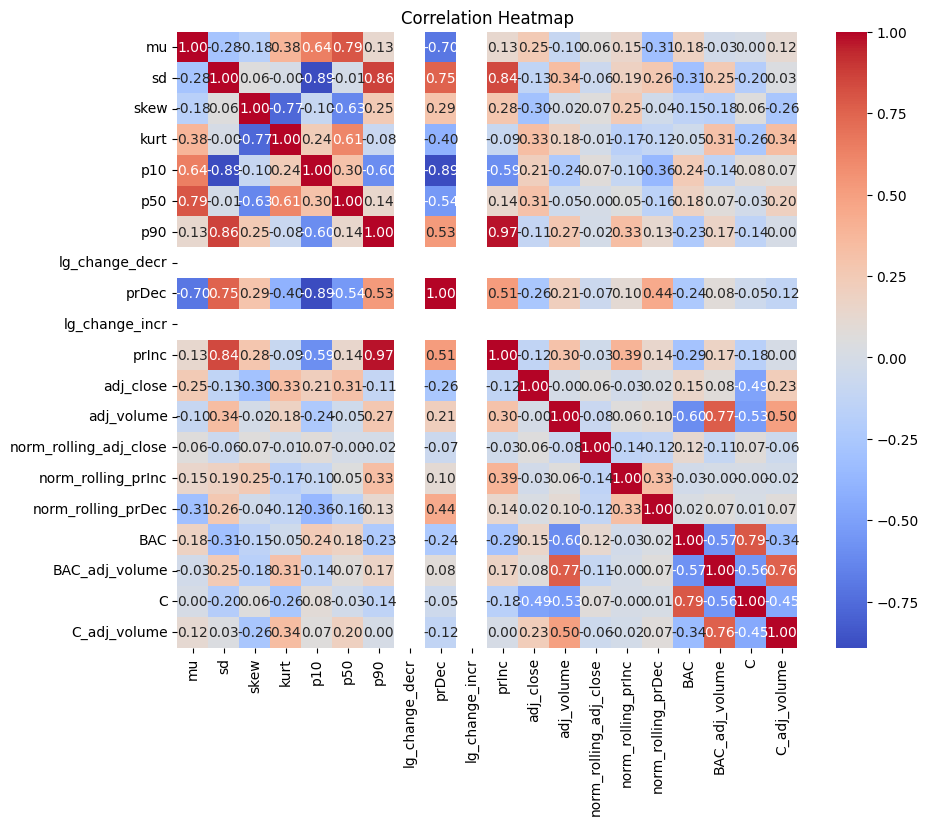

In [30]:
correlation_matrix = spreads_df_merged.corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Price Increase Probablity as spread

In [813]:
cap=1e9

In [814]:
spreads_df_merged['spread'] = spreads_df_merged['prInc']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,141099400.0,0.832208,-0.673149,-0.436029,13.288031,181616500.0,27.893554,80789300.0,-0.03009,1.000000e+09
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,107192400.0,0.813632,-0.255042,-0.237301,12.555235,159503300.0,26.317647,23577600.0,-0.00855,1.000000e+09
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,143892400.0,0.852511,0.532523,-0.505714,12.343539,205493300.0,26.081261,33228500.0,0.03234,1.000000e+09
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,325813700.0,0.879605,-0.343343,-1.362086,13.605576,170931100.0,26.711624,15568600.0,-0.01294,1.000000e+09
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,56825300.0,0.548147,-1.206253,-2.329349,13.874596,107411800.0,31.912117,54320500.0,-0.05782,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,36984538.0,0.771496,-0.220263,-0.202726,33.940000,106386482.0,49.765108,50978775.0,-0.00612,1.000000e+09
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,27647540.0,0.802099,-0.138480,-0.164737,33.200000,32146583.0,50.121705,13083552.0,-0.00199,1.000000e+09
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,14599441.0,0.765612,-0.202116,-0.232332,33.880000,21731860.0,51.033009,9632493.0,-0.00524,1.000000e+09


In [815]:

def tune_hyperparameter(spreads_df, K= 1e10, g=0.03, j=0, s=-100, tc=0, reverse=False, interactive_plot=True):
    def get_raw_positions(spreads_df, sl_exit):
        spreads_df = spreads_df.copy()
        spreads_df['signal'] = np.nan

        buy_condition = (spreads_df['spread'] > g) 
        sell_condition = (spreads_df['spread'] < -g)
        
        if reverse:
            cond=sell_condition.copy()
            sell_condition = buy_condition.copy()
            buy_condition = cond.copy()

        # Generate signals
        spreads_df.loc[buy_condition, 'signal'] = 1
        spreads_df.loc[sell_condition, 'signal'] = -1

        spreads_df['position'] = spreads_df['signal'].ffill()

        # Exit the position if the spread becomes flat (goes below j)
        sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
        
        if reverse:
            cond=sell_exit_cond.copy()
            sell_exit_cond = buy_exit_cond.copy()
            buy_exit_cond = cond.copy()
        
        if sl_exit is not None:
            spreads_df.loc[sl_exit, 'signal'] = 0

        # last day exit
        spreads_df['signal'].iloc[-1] = 0

        # normal exits
        spreads_df.loc[sell_exit_cond, 'signal'] = 0
        spreads_df.loc[buy_exit_cond, 'signal'] = 0
        spreads_df['position'] = spreads_df['signal'].ffill()

        # Create new_signal column representing changes in position
        spreads_df['final_signal'] = np.nan
        spreads_df['position'].fillna(0, inplace=True)

        spreads_df['new_position'] = 0
        spreads_df.loc[
            (spreads_df['position'].shift() != spreads_df['position']) & (
                        spreads_df['position'] != 0), 'new_position'] = 1
        spreads_df['position_count'] = spreads_df['new_position'].cumsum()

        spreads_df['final_signal'] = spreads_df['position'].diff()

        return spreads_df

    raw_positions = get_raw_positions(spreads_df, None)

    def process_positions(raw_positions):
        positions_df = raw_positions.copy()

        positions_df[security1 + '_' + 'quantity_held'] = np.nan
        positions_df[security2 + '_' + 'quantity_held'] = np.nan

        positions_df.loc[(positions_df.final_signal != 0), security1 + '_' + 'quantity_held'] = positions_df[
                                                                                                    'position'] * (
                                                                                                        positions_df[
                                                                                                            'dollars_available'] /
                                                                                                        positions_df[
                                                                                                            security1]).round()
        positions_df.loc[(positions_df.final_signal != 0), security2 + '_' + 'quantity_held'] = -1 * positions_df[
            'position'] * (positions_df['dollars_available'] / positions_df[security2]).round()

        positions_df[security1 + '_' + 'quantity_held'].ffill(inplace=True)
        positions_df[security2 + '_' + 'quantity_held'].ffill(inplace=True)

        positions_df['net_dollar_position'] = (
                    positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1] +
                    positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2])
        positions_df['gross_dollar_position'] = (
                (positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1]).abs() +
                (positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2]).abs())
        positions_df['net_dollar_position_change'] = (
                positions_df[security1 + '_' + 'quantity_held'].shift() * positions_df[security1].diff() +
                positions_df[security2 + '_' + 'quantity_held'].shift() * positions_df[security2].diff()).shift(-1)

        positions_df['transaction_cost'] = (
                                                   positions_df[security1 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security1] +
                                                   positions_df[security2 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security2]) * tc

        positions_df['position_pnl'] = positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum()

        positions_df['position_returns'] = (
                positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum() /
                positions_df.groupby('position_count')['gross_dollar_position'].transform('first'))

        return positions_df

    positions = process_positions(raw_positions)

    def implement_stop_loss(positions, sl_implemented):

        positions_df = positions.copy()

        positions_df['sl_not_hit'] = np.nan
        positions_df.loc[positions_df['new_position'] == 1, 'sl_not_hit'] = 1
        positions_df.loc[positions_df.groupby('position_count')['position_returns'].shift() <= s, 'sl_not_hit'] = 0
        positions_df['sl_not_hit'].ffill(inplace=True)
        positions_df['sl_not_hit'].fillna(1, inplace=True)

        positions_df['month'] = positions_df.index.strftime('%Y-%m')
        positions_df['monthly_sl_not_hit'] = positions_df.groupby('month')['sl_not_hit'].cummin()
        sl_exits = positions_df['monthly_sl_not_hit'] == 0

        if sl_implemented:
            return positions_df

        spreads_df = positions_df.loc[:, :'dollars_available']
        raw_positions = get_raw_positions(spreads_df, sl_exits)
        final_positions = process_positions(raw_positions)

        final_positions_sl = implement_stop_loss(final_positions, True)
        return final_positions_sl

    positions_sl_implemented = implement_stop_loss(positions, False)

    def calculate_and_plot_pnl(positions):

        positions = positions.copy()

        grouped_pnl_pct = (positions.groupby('position_count')['net_dollar_position_change'].sum() -
                           positions.groupby('position_count')['transaction_cost'].sum()) / \
                          positions.groupby('position_count')['gross_dollar_position'].first()

        positions['total_pnl'] = positions['net_dollar_position_change'].cumsum() - positions[
            'transaction_cost'].cumsum()
        positions['cumulative_pnl'] = positions['total_pnl'] + K

        return grouped_pnl_pct, positions

    grouped_pnl_pct, positions_pnl = calculate_and_plot_pnl(positions_sl_implemented)

    plt.figure(figsize=(12, 8))
    positions_pnl.total_pnl.plot(color='blue', linewidth=2, label='Total PnL')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total PnL (USD)', fontsize=14)
    plt.title('Total PnL Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

    cumulative_pnl = positions_pnl['cumulative_pnl'].dropna()
    cumulative_returns_percentage = ((cumulative_pnl / cumulative_pnl.iloc[0] - 1) * 100)
    cumulative_returns_percentage.plot(figsize=(12, 8), color='green', linewidth=2)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.title('Cumulative Returns Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    if not interactive_plot:
        return grouped_pnl_pct, positions_pnl

    return positions_pnl.total_pnl



In [816]:

# tune_hyperparameter(spreads_df_merged,K =1e10, g=0.03, j=0, s=-100, tc=0, interactive_plot=True)


In [817]:
from ipywidgets import interactive

# Define your function that generates the plot based on parameters
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc,reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 0.05, num=501)
j_slider = np.linspace(0, 0.05, num=501)
s_slider = np.linspace(-100, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


In [818]:
# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

# Strategy based on price decrease probablity

In [819]:
spreads_df_merged['spread'] = -spreads_df_merged['prDec']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,141099400.0,0.832208,-0.673149,-0.436029,13.288031,181616500.0,27.893554,80789300.0,0.03349,1.000000e+09
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,107192400.0,0.813632,-0.255042,-0.237301,12.555235,159503300.0,26.317647,23577600.0,0.02622,1.000000e+09
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,143892400.0,0.852511,0.532523,-0.505714,12.343539,205493300.0,26.081261,33228500.0,0.03983,1.000000e+09
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,325813700.0,0.879605,-0.343343,-1.362086,13.605576,170931100.0,26.711624,15568600.0,0.07900,1.000000e+09
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,56825300.0,0.548147,-1.206253,-2.329349,13.874596,107411800.0,31.912117,54320500.0,0.12750,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,36984538.0,0.771496,-0.220263,-0.202726,33.940000,106386482.0,49.765108,50978775.0,0.00451,1.000000e+09
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,27647540.0,0.802099,-0.138480,-0.164737,33.200000,32146583.0,50.121705,13083552.0,0.00404,1.000000e+09
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,14599441.0,0.765612,-0.202116,-0.232332,33.880000,21731860.0,51.033009,9632493.0,0.00678,1.000000e+09


In [820]:
from ipywidgets import interactive

# Define your function that generates the plot based on parameters
def update_plot(K=1e10, g=0.03, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 0.05, num=501)
j_slider = np.linspace(0, 0.05, num=501)
s_slider = np.linspace(-100, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=True)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

### We see that for the same set of parameters for a strategy, Price Increase porbablity and price decrease probablity lead to very different PnL.

## Strategy based on normalized increasing probablities

In [821]:
spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,141099400.0,0.832208,-0.673149,-0.436029,13.288031,181616500.0,27.893554,80789300.0,-0.673149,1.000000e+09
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,107192400.0,0.813632,-0.255042,-0.237301,12.555235,159503300.0,26.317647,23577600.0,-0.255042,1.000000e+09
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,143892400.0,0.852511,0.532523,-0.505714,12.343539,205493300.0,26.081261,33228500.0,0.532523,1.000000e+09
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,325813700.0,0.879605,-0.343343,-1.362086,13.605576,170931100.0,26.711624,15568600.0,-0.343343,1.000000e+09
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,56825300.0,0.548147,-1.206253,-2.329349,13.874596,107411800.0,31.912117,54320500.0,-1.206253,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,36984538.0,0.771496,-0.220263,-0.202726,33.940000,106386482.0,49.765108,50978775.0,-0.220263,1.000000e+09
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,27647540.0,0.802099,-0.138480,-0.164737,33.200000,32146583.0,50.121705,13083552.0,-0.138480,1.000000e+09
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,14599441.0,0.765612,-0.202116,-0.232332,33.880000,21731860.0,51.033009,9632493.0,-0.202116,1.000000e+09


In [822]:

# signals reverse
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 5, num=501)
j_slider = np.linspace(0, 5, num=501)
s_slider = np.linspace(-0.01, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

## Strategy based on normalized decreasing probablities

In [823]:
spreads_df_merged['spread'] = -spreads_df_merged['norm_rolling_prDec']
spreads_df_merged['dollars_available'] = 1e9
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,141099400.0,0.832208,-0.673149,-0.436029,13.288031,181616500.0,27.893554,80789300.0,0.436029,1.000000e+09
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,107192400.0,0.813632,-0.255042,-0.237301,12.555235,159503300.0,26.317647,23577600.0,0.237301,1.000000e+09
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,143892400.0,0.852511,0.532523,-0.505714,12.343539,205493300.0,26.081261,33228500.0,0.505714,1.000000e+09
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,325813700.0,0.879605,-0.343343,-1.362086,13.605576,170931100.0,26.711624,15568600.0,1.362086,1.000000e+09
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,56825300.0,0.548147,-1.206253,-2.329349,13.874596,107411800.0,31.912117,54320500.0,2.329349,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,36984538.0,0.771496,-0.220263,-0.202726,33.940000,106386482.0,49.765108,50978775.0,0.202726,1.000000e+09
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,27647540.0,0.802099,-0.138480,-0.164737,33.200000,32146583.0,50.121705,13083552.0,0.164737,1.000000e+09
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,14599441.0,0.765612,-0.202116,-0.232332,33.880000,21731860.0,51.033009,9632493.0,0.232332,1.000000e+09


In [824]:

# signals reverse
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 5, num=501)
j_slider = np.linspace(-1, 5, num=601)
s_slider = np.linspace(-0.01, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

# Strategy based on both price and probability spreads

In [825]:

def two_spread_strat(spreads_df, K= 1e10, g=0.03, g2=0, j=0, s=-100, tc=0, reverse=False, interactive_plot=True):
    
    def get_raw_positions(spreads_df, sl_exit):
        spreads_df = spreads_df.copy()
        spreads_df['signal'] = np.nan

        buy_condition = (spreads_df['spread'] > g)  & (spreads_df['spread2'] < g2)
        sell_condition = (spreads_df['spread'] < -g) & (spreads_df['spread2'] > -g2)
        
        if reverse:
            sell_condition = (spreads_df['spread'] > g)  & (spreads_df['spread2'] < g2)
            buy_condition = (spreads_df['spread'] < -g) & (spreads_df['spread2'] > -g2)

        # Generate signals
        spreads_df.loc[buy_condition, 'signal'] = 1
        spreads_df.loc[sell_condition, 'signal'] = -1

        spreads_df['position'] = spreads_df['signal'].ffill()

        # Exit the position if the spread becomes flat (goes below j)
        sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
        
        if reverse:
            sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
            buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        
        if sl_exit is not None:
            spreads_df.loc[sl_exit, 'signal'] = 0

        # last day exit
        spreads_df['signal'].iloc[-1] = 0

        # normal exits
        spreads_df.loc[sell_exit_cond, 'signal'] = 0
        spreads_df.loc[buy_exit_cond, 'signal'] = 0
        spreads_df['position'] = spreads_df['signal'].ffill()

        # Create new_signal column representing changes in position
        spreads_df['final_signal'] = np.nan
        spreads_df['position'].fillna(0, inplace=True)

        spreads_df['new_position'] = 0
        spreads_df.loc[
            (spreads_df['position'].shift() != spreads_df['position']) & (
                        spreads_df['position'] != 0), 'new_position'] = 1
        spreads_df['position_count'] = spreads_df['new_position'].cumsum()

        spreads_df['final_signal'] = spreads_df['position'].diff()

        return spreads_df

    raw_positions = get_raw_positions(spreads_df, None)

    def process_positions(raw_positions):
        positions_df = raw_positions.copy()

        positions_df[security1 + '_' + 'quantity_held'] = np.nan
        positions_df[security2 + '_' + 'quantity_held'] = np.nan

        positions_df.loc[(positions_df.final_signal != 0), security1 + '_' + 'quantity_held'] = positions_df[
                                                                                                    'position'] * (
                                                                                                        positions_df[
                                                                                                            'dollars_available'] /
                                                                                                        positions_df[
                                                                                                            security1]).round()
        positions_df.loc[(positions_df.final_signal != 0), security2 + '_' + 'quantity_held'] = -1 * positions_df[
            'position'] * (positions_df['dollars_available'] / positions_df[security2]).round()

        positions_df[security1 + '_' + 'quantity_held'].ffill(inplace=True)
        positions_df[security2 + '_' + 'quantity_held'].ffill(inplace=True)

        positions_df['net_dollar_position'] = (
                    positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1] +
                    positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2])
        positions_df['gross_dollar_position'] = (
                (positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1]).abs() +
                (positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2]).abs())
        positions_df['net_dollar_position_change'] = (
                positions_df[security1 + '_' + 'quantity_held'].shift() * positions_df[security1].diff() +
                positions_df[security2 + '_' + 'quantity_held'].shift() * positions_df[security2].diff()).shift(-1)

        positions_df['transaction_cost'] = (
                                                   positions_df[security1 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security1] +
                                                   positions_df[security2 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security2]) * tc

        positions_df['position_pnl'] = positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum()

        positions_df['position_returns'] = (
                positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum() /
                positions_df.groupby('position_count')['gross_dollar_position'].transform('first'))

        return positions_df

    positions = process_positions(raw_positions)

    def implement_stop_loss(positions, sl_implemented):

        positions_df = positions.copy()

        positions_df['sl_not_hit'] = np.nan
        positions_df.loc[positions_df['new_position'] == 1, 'sl_not_hit'] = 1
        positions_df.loc[positions_df.groupby('position_count')['position_returns'].shift() <= s, 'sl_not_hit'] = 0
        positions_df['sl_not_hit'].ffill(inplace=True)
        positions_df['sl_not_hit'].fillna(1, inplace=True)

        sl_exits = positions_df['sl_not_hit'] == 0

        if sl_implemented:
            return positions_df

        spreads_df = positions_df.loc[:, :'spread2']
        raw_positions = get_raw_positions(spreads_df, sl_exits)
        final_positions = process_positions(raw_positions)

        final_positions_sl = implement_stop_loss(final_positions, True)
        return final_positions_sl

    positions_sl_implemented = implement_stop_loss(positions, False)

    def calculate_and_plot_pnl(positions):

        positions = positions.copy()

        grouped_pnl_pct = (positions.groupby('position_count')['net_dollar_position_change'].sum() -
                           positions.groupby('position_count')['transaction_cost'].sum()) 
#         / \
#                           positions.groupby('position_count')['gross_dollar_position'].first()

        positions['total_pnl'] = positions['net_dollar_position_change'].cumsum() - positions[
            'transaction_cost'].cumsum()
        positions['cumulative_pnl'] = positions['total_pnl'] + K

        return grouped_pnl_pct, positions

    grouped_pnl_pct, positions_pnl = calculate_and_plot_pnl(positions_sl_implemented)

    if not interactive_plot:
        return grouped_pnl_pct, positions_pnl

    
    plt.figure(figsize=(12, 8))
    positions_pnl.total_pnl.plot(color='blue', linewidth=2, label='Total PnL')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total PnL (USD)', fontsize=14)
    plt.title('Total PnL Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

    cumulative_pnl = positions_pnl['cumulative_pnl'].dropna()
    cumulative_returns_percentage = ((cumulative_pnl / cumulative_pnl.iloc[0] - 1) * 100)
    cumulative_returns_percentage.plot(figsize=(12, 8), color='green', linewidth=2)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.title('Cumulative Returns Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    return positions_pnl.total_pnl



In [826]:
spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
spreads_df_merged['spread2'] = spreads_df_merged['norm_rolling_adj_close']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,0.832208,-0.673149,-0.436029,13.288031,181616500.0,27.893554,80789300.0,-0.673149,1.000000e+09,0.832208
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,0.813632,-0.255042,-0.237301,12.555235,159503300.0,26.317647,23577600.0,-0.255042,1.000000e+09,0.813632
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,0.852511,0.532523,-0.505714,12.343539,205493300.0,26.081261,33228500.0,0.532523,1.000000e+09,0.852511
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,0.879605,-0.343343,-1.362086,13.605576,170931100.0,26.711624,15568600.0,-0.343343,1.000000e+09,0.879605
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,0.548147,-1.206253,-2.329349,13.874596,107411800.0,31.912117,54320500.0,-1.206253,1.000000e+09,0.548147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,0.771496,-0.220263,-0.202726,33.940000,106386482.0,49.765108,50978775.0,-0.220263,1.000000e+09,0.771496
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,0.802099,-0.138480,-0.164737,33.200000,32146583.0,50.121705,13083552.0,-0.138480,1.000000e+09,0.802099
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,0.765612,-0.202116,-0.232332,33.880000,21731860.0,51.033009,9632493.0,-0.202116,1.000000e+09,0.765612


In [827]:
spreads_df_merged.columns

Index(['mu', 'sd', 'skew', 'kurt', 'p10', 'p50', 'p90', 'lg_change_decr',
       'prDec', 'lg_change_incr', 'prInc', 'adj_close', 'adj_volume',
       'norm_rolling_adj_close', 'norm_rolling_prInc', 'norm_rolling_prDec',
       'BAC', 'BAC_adj_volume', 'C', 'C_adj_volume', 'spread',
       'dollars_available', 'spread2'],
      dtype='object')

In [828]:
# Pr inc and Price thresholds
# signals reverse
def update_plot(K=1e10, g=0, g2=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = two_spread_strat(spreads_df_merged,K, g, g2, j, s, tc, reverse)


g_slider = np.linspace(0, 5, num=501)
g2_slider = np.linspace(-1, 5, num=601)
j_slider = np.linspace(-1, 5, num=601)
s_slider = np.linspace(-0.1, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, g2=g2_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

In [829]:
def plot_signals(positions, upper_threshold, exit_threshold):
    """
    Plot spread with buy, sell, and exit signals, along with threshold boundaries.

    Parameters:
    - positions (pd.DataFrame): DataFrame containing spread and signal information.
    - upper_threshold (float): Upper threshold for buy signals.
    - exit_threshold (float): Threshold for exit signals.

    Returns:
    - None
    """

    # Create a DataFrame for threshold boundaries
    margin_boundary = pd.DataFrame(index=positions.index)
    margin_boundary["Upper Threshold (g)"] = upper_threshold
    margin_boundary["Lower Threshold (-g)"] = -upper_threshold
    margin_boundary["Exit Threshold (j)"] = exit_threshold
    margin_boundary["Exit Threshold (-j)"] = -exit_threshold

    # Plot spread over time
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.plot(positions['spread2'], label='Spread')

    # Plot green dots for buy signals
    ax.plot(positions.loc[(positions["position"] == 1) & (positions["position"].shift() == 0)]['spread2'], '^', markersize=10, color='green', label='Buy Signal')

    # Plot red dots for short signals
    ax.plot(positions.loc[(positions["position"] == -1) & (positions["position"].shift() == 0)]['spread2'], 'v', markersize=10, color='red', label='Short Signal')

    # Plot blue dots for exit signals
    ax.plot(positions.loc[(positions["position"] == 0) & positions["position"].shift() != 0]['spread2'], 'o', markersize=5, color='blue', label='Exit Signal')

    # Plot Red dots for stop loss exit signals
    ax.plot(positions.loc[(positions["sl_not_hit"].diff().dropna() != 0) & 
                          (positions["final_signal"].isin([1, -1]))]['spread2'], 'o', markersize=10, 
            color='red', label='Stop Loss Exit Signal')

    
    # Plot threshold boundaries
    ax.plot(margin_boundary['Upper Threshold (g)'], color='red', label='Sell Threshold')
    ax.plot(margin_boundary['Lower Threshold (-g)'], color='green', label='Buy Threshold')
    ax.plot(margin_boundary['Exit Threshold (j)'], color='red', linestyle='--', label='Sell Exit Threshold')
    ax.plot(margin_boundary['Exit Threshold (-j)'], color='green', linestyle='--', label='Buy Exit Threshold')


    # Customize plot appearance
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Spread', fontsize=14)
    ax.set_title('Spread with Buy/Sell/Exit Signals and Thresholds', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()


In [1006]:
gp, positions_pnl = two_spread_strat(spreads_df_merged, K= cap, g=0.2, g2=0, j=0, s=-100, tc=0, reverse=True, interactive_plot=False)


In [1007]:
# positions_pnl

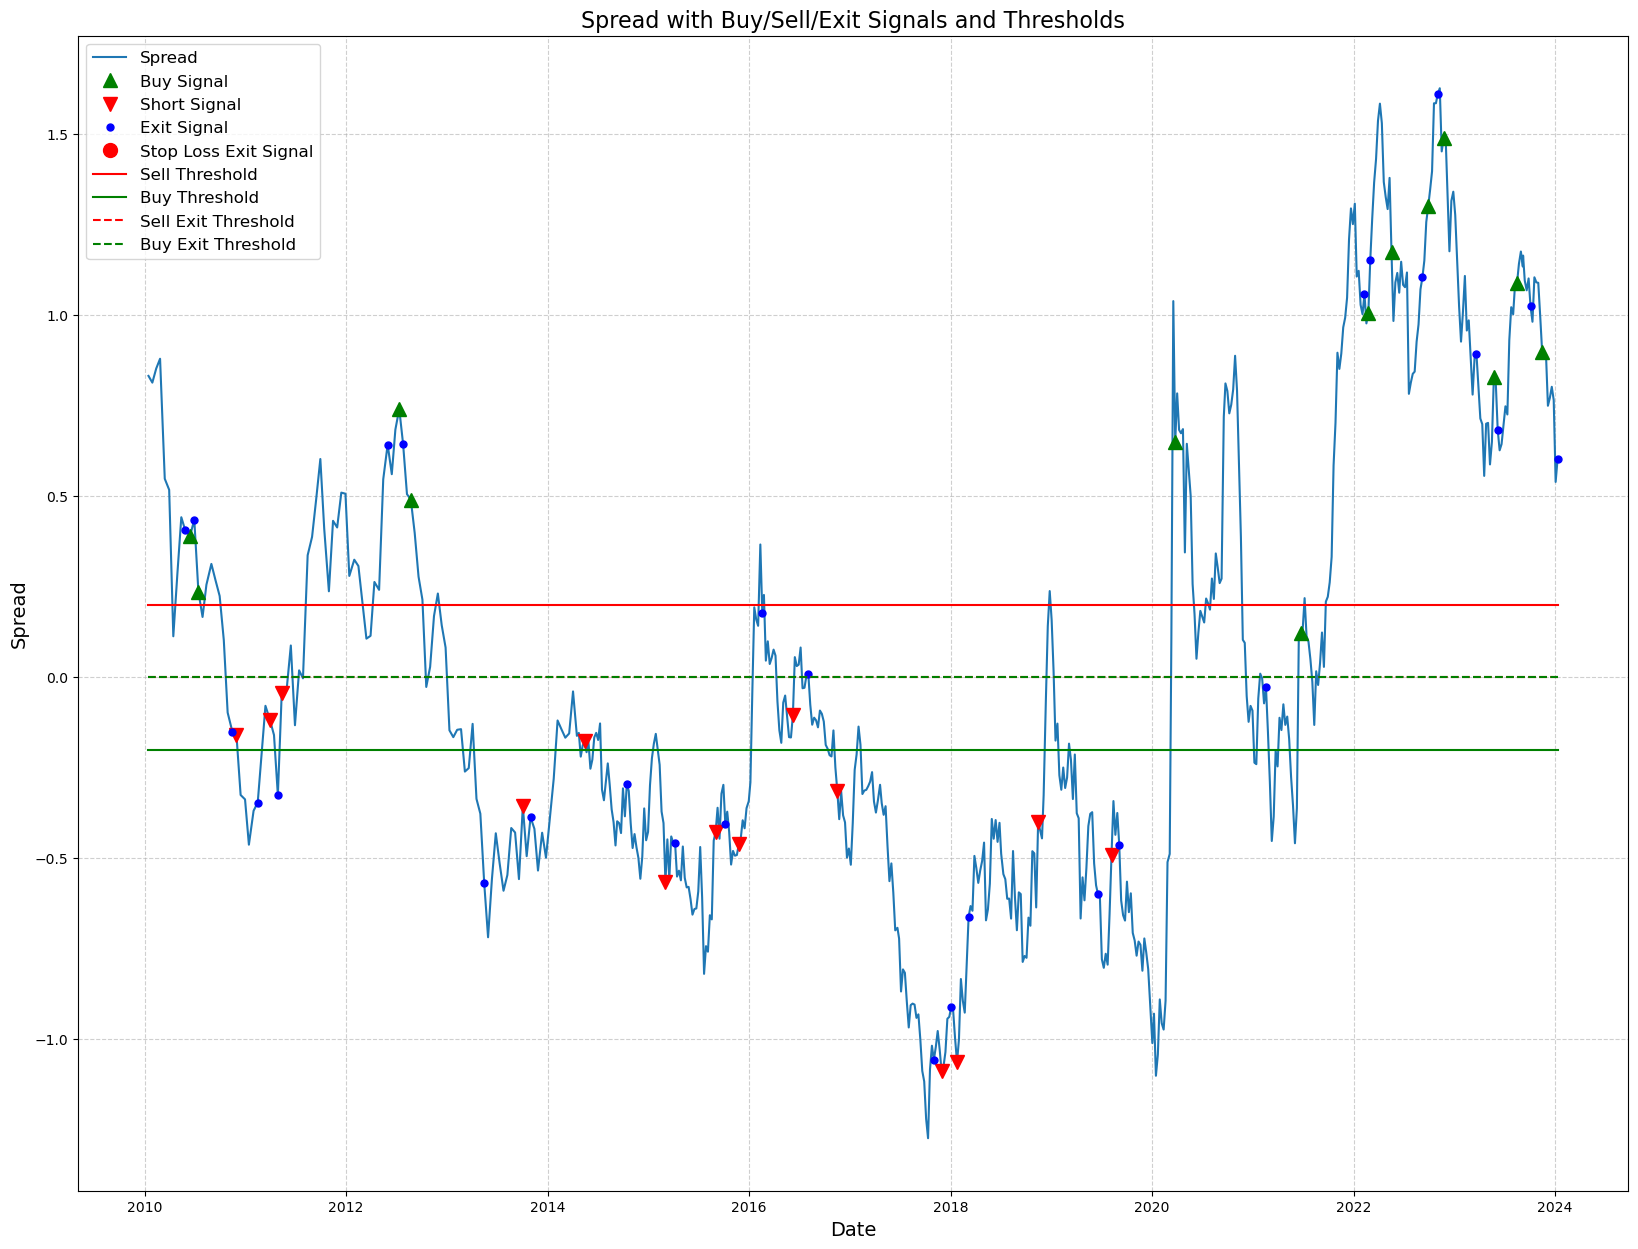

In [1012]:
plot_signals(positions_pnl, 0.2, 0)

In [1009]:
daily_start_ret = (positions_pnl.total_pnl.diff() / cap).to_frame('strat_returns').dropna()
daily_start_ret

,strat_returns
date,
2010-02-12,0.072377
2010-02-26,-0.166195
2010-03-15,0.025202
2010-03-31,-0.084659
2010-04-15,0.020914
...,...
2023-11-29,-0.047927
2023-12-06,0.072958
2023-12-13,-0.033307


In [1010]:
#hit rate
len(gp[gp>0])/len(gp[gp!=0])

0.3235294117647059

In [1011]:
gp

position_count
1    -1.409143e+08
2    -6.394057e+07
3    -2.408760e+08
4    -2.139340e+07
5    -1.749027e+08
6     8.602691e+07
7     1.677725e+08
8     2.305603e+08
9    -8.960764e+07
10   -8.740786e+07
11   -3.974554e+07
12   -5.801444e+06
13   -4.086858e+07
14   -8.574029e+06
15    9.216474e+06
16   -2.583265e+07
17   -6.437638e+07
18    5.088518e+05
19    4.737778e+07
20   -4.695425e+07
21   -7.157504e+07
22   -7.047153e+07
23   -7.706911e+07
24   -1.524408e+08
25   -3.174521e+06
26    9.610769e+07
27    2.450988e+08
28    2.962976e+07
29    5.948962e+06
30    1.189174e+08
31   -1.843604e+08
32   -4.165113e+07
33   -4.175908e+07
34   -5.049832e+07
dtype: float64

In [1013]:
# spy ret

In [1014]:
@functools.lru_cache(maxsize=16)
def fetch_etf_data_quadl(ticker,start_date,end_date):
    return quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte':start_date,'lte': end_date}, ticker=ticker)

In [1015]:
spy_data = fetch_etf_data_quadl('SPY', '2010-01-15','2024-01-10')

In [1016]:
spy_data = spy_data.set_index('date')
spy_data['spy_adj_close'] = spy_data.adj_close.replace(np.inf, np.nan)
spy_data

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,spy_adj_close
date,,,,,,,,,,,,,,
2024-01-10,SPY,474.160000,477.448100,473.870000,476.560000,66379545.0,0.0,1.0,474.160000,477.448100,473.870000,476.560000,66379545.0,476.560000
2024-01-09,SPY,471.870000,474.930000,471.350000,473.880000,65497238.0,0.0,1.0,471.870000,474.930000,471.350000,473.880000,65497238.0,473.880000
2024-01-08,SPY,468.430000,474.750000,468.300000,474.600000,74232526.0,0.0,1.0,468.430000,474.750000,468.300000,474.600000,74232526.0,474.600000
2024-01-05,SPY,467.490000,470.440000,466.430000,467.920000,85713902.0,0.0,1.0,467.490000,470.440000,466.430000,467.920000,85713902.0,467.920000
2024-01-04,SPY,468.300000,470.960000,467.050000,467.280000,83250038.0,0.0,1.0,468.300000,470.960000,467.050000,467.280000,83250038.0,467.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-22,SPY,111.199997,111.739998,109.089996,109.209999,345942400.0,0.0,1.0,85.421849,85.836668,83.800984,83.893168,345942400.0,83.893168
2010-01-21,SPY,113.919998,114.269997,111.559998,111.699997,344859600.0,0.0,1.0,87.511305,87.780168,85.698395,85.805940,344859600.0,85.805940
2010-01-20,SPY,114.279999,114.449997,112.980003,113.889999,216490200.0,0.0,1.0,87.787851,87.918440,86.789217,87.488260,216490200.0,87.488260


In [1017]:
merged_ret_df = daily_start_ret.merge(spy_data[['spy_adj_close']], left_index=True, right_index=True)
merged_ret_df['spy_returns'] = merged_ret_df['spy_adj_close'].pct_change()
merged_ret_df = merged_ret_df.replace(np.inf,np.nan)
merged_ret_df = merged_ret_df.dropna()
merged_ret_df

,strat_returns,spy_adj_close,spy_returns
date,,,
2010-02-26,-0.166195,85.068486,0.024991
2010-03-15,0.025202,88.717351,0.042893
2010-03-31,-0.084659,90.249309,0.017268
2010-04-15,0.020914,93.558452,0.036667
2010-04-30,0.050524,91.645472,-0.020447
...,...,...,...
2023-11-29,-0.047927,452.771177,-0.000901
2023-12-06,0.072958,452.920570,0.000330
2023-12-13,-0.033307,468.596904,0.034612


In [1018]:
merged_ret_df.corr()

,strat_returns,spy_adj_close,spy_returns
strat_returns,1.000000,0.064865,-0.054349
spy_adj_close,0.064865,1.000000,-0.007937
spy_returns,-0.054349,-0.007937,1.000000


In [1019]:
X = merged_ret_df[['spy_returns']]
X = sm.add_constant(X)
model = sm.OLS(X,merged_ret_df[['strat_returns']])

results = model.fit()
results.params


,0,1
strat_returns,-1.973154,-0.055654


# Hyperparameter tuning on training data

In [1035]:
seed = 1155

In [1036]:
def objective(trial:Trial,train=None):

    g = trial.suggest_float('g', 0, 5, step=0.01)
    g2 = trial.suggest_float('g2', -5, 5, step=0.01)
    j = trial.suggest_float('j', 0, g, step=0.01)
    s = trial.suggest_float('s', -0.1, 0, step=0.001)
    reverse = trial.suggest_int('reverse',0,1, step=1)
    
    grouped_pnl, positions_pnl = two_spread_strat(train, K= cap, g=g, g2=g2, j=j, s=s, tc=0, reverse=bool(reverse), interactive_plot=False)

    return positions_pnl['net_dollar_position_change'].sum()

In [1037]:
# Trial.suggest_float('g', 0, 5, step=0.1)

In [1038]:
study = optuna.create_study(direction="maximize")


In [1024]:
# train test split

In [1025]:
split = 0.5

In [1026]:
train = spreads_df_merged.iloc[:int(len(spreads_df_merged) * split)]
test = spreads_df_merged.iloc[int(len(spreads_df_merged) * (split)):]

In [1027]:
train

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,0.832208,-0.673149,-0.436029,13.288031,181616500.0,27.893554,80789300.0,-0.673149,1.000000e+09,0.832208
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,0.813632,-0.255042,-0.237301,12.555235,159503300.0,26.317647,23577600.0,-0.255042,1.000000e+09,0.813632
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,0.852511,0.532523,-0.505714,12.343539,205493300.0,26.081261,33228500.0,0.532523,1.000000e+09,0.852511
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,0.879605,-0.343343,-1.362086,13.605576,170931100.0,26.711624,15568600.0,-0.343343,1.000000e+09,0.879605
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,0.548147,-1.206253,-2.329349,13.874596,107411800.0,31.912117,54320500.0,-1.206253,1.000000e+09,0.548147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-17,-0.00605,0.01985,-0.04026,-0.20163,-0.03306,-0.00448,0.01989,0.0,0.02829,0.0,...,-0.998683,0.169144,0.441497,27.366592,76440397.0,62.866377,15411013.0,0.169144,1.000000e+09,-0.998683
2018-01-24,-0.00751,0.02593,0.12463,-0.09315,-0.03944,-0.00825,0.02632,0.0,0.03144,0.0,...,-1.063068,0.311966,0.470152,27.896885,62265824.0,64.531658,16178829.0,0.311966,1.000000e+09,-1.063068
2018-01-31,0.00106,0.00951,0.09845,-0.23581,-0.01051,-0.00090,0.01675,0.0,0.00880,0.0,...,-1.000004,0.144033,0.060024,28.253312,62367448.0,64.336698,12437151.0,0.144033,1.000000e+09,-1.000004


In [1028]:
# train.iloc[:60]

In [1029]:
test

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,0.00134,0.00783,0.11923,-0.39837,-0.01207,0.00114,0.01265,0.0,0.00914,0.0,...,-0.926563,0.109717,0.075805,27.549152,64749717.0,62.213980,16049529.0,0.109717,1.000000e+09,-0.926563
2018-02-28,0.00011,0.00716,0.02581,-0.32530,-0.01272,0.00082,0.01000,0.0,0.01054,0.0,...,-0.795145,0.013697,0.112990,27.470912,90547117.0,60.084985,23803242.0,0.013697,1.000000e+09,-0.795145
2018-03-07,0.00061,0.00621,-0.05048,-0.11698,-0.01119,0.00422,0.00628,0.0,0.00965,0.0,...,-0.661735,-0.057945,0.131481,28.099218,53139846.0,60.452053,10878604.0,-0.057945,1.000000e+09,-0.661735
2018-03-14,0.00142,0.00236,-0.12093,0.18133,-0.00208,0.00396,0.00194,0.0,0.00368,0.0,...,-0.632200,-0.121981,-0.022421,28.011953,41964199.0,59.823959,13334033.0,-0.121981,1.000000e+09,-0.632200
2018-03-21,0.00152,0.00207,0.02250,-0.16976,-0.00160,0.00046,0.00610,0.0,0.00061,0.0,...,-0.645180,-0.063769,-0.114107,26.659351,110271917.0,57.352366,27652345.0,-0.063769,1.000000e+09,-0.645180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,0.771496,-0.220263,-0.202726,33.940000,106386482.0,49.765108,50978775.0,-0.220263,1.000000e+09,0.771496
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,0.802099,-0.138480,-0.164737,33.200000,32146583.0,50.121705,13083552.0,-0.138480,1.000000e+09,0.802099
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,0.765612,-0.202116,-0.232332,33.880000,21731860.0,51.033009,9632493.0,-0.202116,1.000000e+09,0.765612


In [1030]:
%%time
study.optimize(partial(objective,train=train), n_trials=100,n_jobs=-1)

CPU times: user 3.05 s, sys: 562 ms, total: 3.61 s
Wall time: 3.14 s


## Best Hyperparameters

In [1031]:
tuned_args = study.best_params
tuned_args

{'g': 1.25,
 'g2': 3.950000000000001,
 'j': 0.53,
 's': -0.08600000000000001,
 'reverse': 1}

# In-sample performance

<Axes: xlabel='date'>

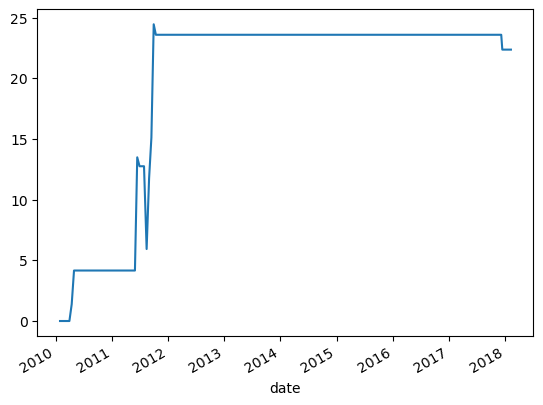

In [1032]:
gp, positions_pnl = two_spread_strat(train, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], s=-100, tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)
((positions_pnl.cumulative_pnl - cap) / cap * 100).plot()

## Out-of Sample performance

<Axes: xlabel='date'>

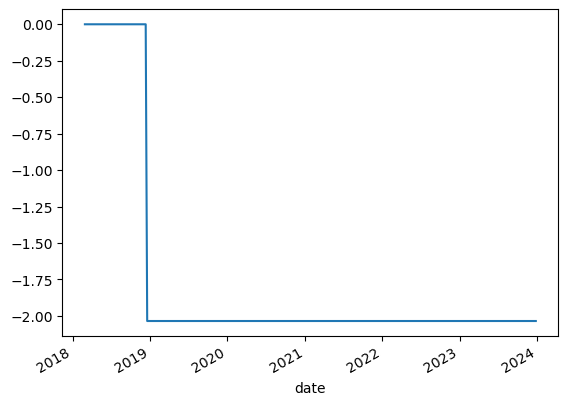

In [1033]:
gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], s=-100, tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)
((positions_pnl.cumulative_pnl - cap) / cap * 100).plot()

# Rolling OOS Performance

insample_lookback = 104 weeks

In [900]:
full_data = spreads_df_merged.copy()
oos_pnl = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(104, len(full_data)-8, 8):
    
    train = spreads_df_merged.iloc[i-104:i]
    test = spreads_df_merged.iloc[i:i+8]

    seed = 1115
    study.optimize(partial(objective,train=train), n_trials=20,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


<Axes: xlabel='date'>

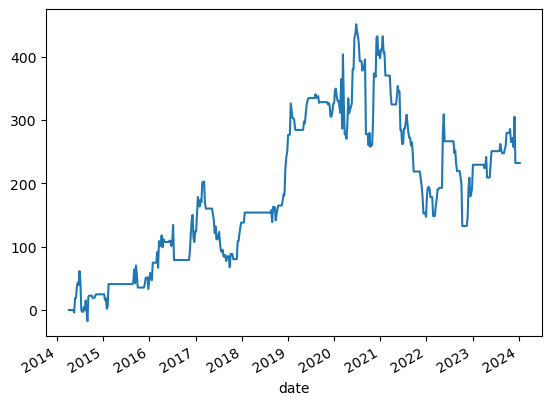

In [928]:
cum_ret = (oos_pnl.fillna(0).cumsum() / cap *10 * 100).loc[spreads_df_merged.index[104:], 'net_pnl']
cum_ret.plot()

# Rolling OOS Performance

insample_lookback = 52 weeks

In [1045]:
seed = 11

In [1046]:
full_data = spreads_df_merged.copy()
oos_pnl = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(52, len(full_data)-4, 4):
    
    train = spreads_df_merged.iloc[i-52:i]
    test = spreads_df_merged.iloc[i:i+4]


    study.optimize(partial(objective,train=train), n_trials=10,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


<Axes: xlabel='date'>

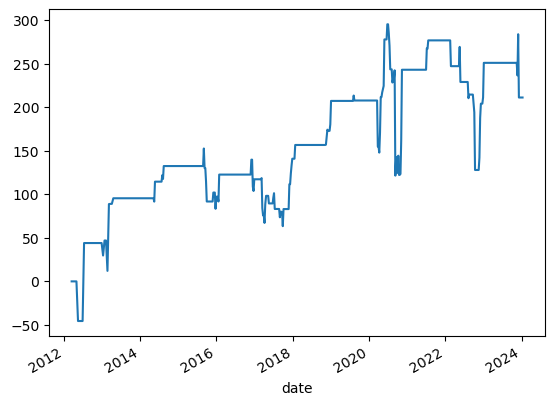

In [1048]:
cum_ret = (oos_pnl.fillna(0).cumsum() / cap *10 * 100).loc[spreads_df_merged.index[52:], 'net_pnl']
cum_ret.plot()

insample_lookback = 26 weeks

In [1049]:
seed = 11

In [1050]:
full_data = spreads_df_merged.copy()
oos_pnl = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(26, len(full_data)-4, 4):
    
    train = spreads_df_merged.iloc[i-26:i]
    test = spreads_df_merged.iloc[i:i+4]


    study.optimize(partial(objective,train=train), n_trials=10,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


<Axes: xlabel='date'>

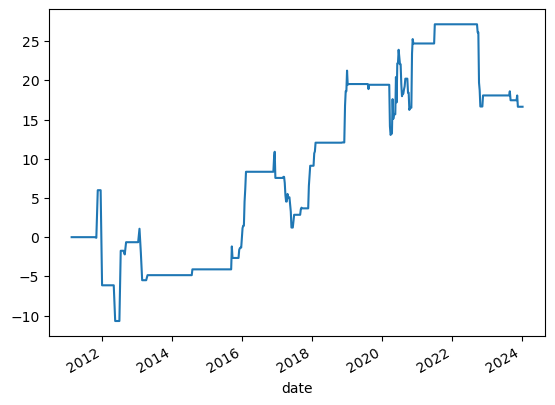

In [1063]:
cum_ret = (oos_pnl.fillna(0).cumsum() / cap * 100).loc[spreads_df_merged.index[26:], 'net_pnl']
cum_ret.plot()

Return stats of OOS ret with  26 lookback 

In [1064]:
oos_pnl['strat_returns']=(oos_pnl.net_pnl.fillna(0)/cap * 10)
oos_pnl

,net_pnl,strat_returns
date,,
2010-01-15,NaN,0.0
2010-01-29,NaN,0.0
2010-02-12,NaN,0.0
2010-02-26,NaN,0.0
2010-03-15,NaN,0.0
...,...,...
2023-12-13,-0.0,-0.0
2023-12-20,0.0,0.0
2023-12-27,NaN,0.0


In [1065]:
#Merging ret with SPY

In [1066]:
merged_ret_df = oos_pnl.merge(spy_data[['spy_adj_close']], left_index=True, right_index=True)
merged_ret_df['spy_returns'] = merged_ret_df['spy_adj_close'].pct_change()
merged_ret_df = merged_ret_df.replace(np.inf,np.nan)
merged_ret_df = merged_ret_df.dropna()
merged_ret_df

,net_pnl,strat_returns,spy_adj_close,spy_returns
date,,,,
2011-02-15,0.0,0.000000,104.182539,0.033649
2011-02-28,0.0,0.000000,104.292196,0.001053
2011-03-15,-0.0,-0.000000,100.696997,-0.034472
2011-04-15,-0.0,-0.000000,103.870425,-0.004148
2011-04-29,0.0,0.000000,107.323857,0.033248
...,...,...,...,...
2023-11-15,6104421.275627,0.061044,447.861118,0.028428
2023-11-22,-14376244.609644,-0.143762,453.179518,0.011875
2023-12-06,0.0,0.000000,452.920570,0.000330


In [1067]:
merged_ret_df.corr()

,net_pnl,strat_returns,spy_adj_close,spy_returns
net_pnl,1.000000,1.000000,-0.010183,-0.003388
strat_returns,1.000000,1.000000,-0.010183,-0.003388
spy_adj_close,-0.010183,-0.010183,1.000000,0.036201
spy_returns,-0.003388,-0.003388,0.036201,1.000000


In [1068]:
non_zero_ret = merged_ret_df[merged_ret_df['strat_returns']!=0]
non_zero_ret.corr()

,net_pnl,strat_returns,spy_adj_close,spy_returns
net_pnl,1.000000,1.000000,-0.015445,-0.008817
strat_returns,1.000000,1.000000,-0.015445,-0.008817
spy_adj_close,-0.015445,-0.015445,1.000000,0.190056
spy_returns,-0.008817,-0.008817,0.190056,1.000000


In [1069]:
X = non_zero_ret[['spy_returns']]
X = sm.add_constant(X)
model = sm.OLS(X,non_zero_ret[['strat_returns']])

results = model.fit()
results.params

,0,1
strat_returns,0.247741,0.000209


### almost 0 Beta to SPY. so strategy is really uncorrelated to market

### OOS Hit Rate

In [1070]:
ret=non_zero_ret['strat_returns']
len(ret[ret>0])/len(ret)

0.6043956043956044

In [1071]:
def performance_summary(return_data,annualization=52):
    """
    Returns the Performance Stats for a given set of future spreads.
    
    Inputs: 
        spread_data - DataFrame with Date index and Daily Values for a certain futures spread.
    
    Output:
        summary_stats - DataFrame with mean, volatility, and drawdown based on daily spreads.
    """
    # Calculate daily returns from spreads
    
    summary_stats = return_data.mean().to_frame('Ann Mean').apply(lambda x: x * annualization)
    summary_stats['Ann Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Ann Mean'] / summary_stats['Ann Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()

    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
#     summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
#     summary_stats['Bottom'] = drawdowns.idxmin()

    return summary_stats

In [1072]:
performance_summary(merged_ret_df[['strat_returns', 'spy_returns']],annualization=52)

,Ann Mean,Ann Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
strat_returns,0.197490,0.893440,0.221045,-0.886574,34.218396,-0.098756,-0.298986,-2.124725
spy_returns,0.170683,0.159453,1.070426,-0.479239,3.332414,-0.035444,-0.054258,-0.189100


In [1073]:
# Even though sharpe is less, this is pure alpha because no market correlation